# 推薦系統

1. 音樂數據處理 : 讀取音樂數據集，對音樂數據集進行數據清洗和特徵提取，並統計其各項指標，選擇有價值的信息當做特徵(大眾化推薦)

2. 基於商品相似性的推薦 : 選擇相似度計算方法，通過相似度來計算推薦結果(個性化推薦)

3. 基於SVD矩陣分解的推薦 : 使用矩陣分解方法，快速高效得到推薦結果(個性化推薦)

### 請解壓縮data.rar，取得本程式之數據

In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import *  # 用在稀疏矩陣的矩陣乘法
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

## 數據讀取

在數據中只有用戶，歌曲，播放量

In [2]:
song_dataset = pd.read_csv(filepath_or_buffer = './train_songs.txt', 
                           sep = '\t', 
                           header = None , 
                           nrows = 300000 ,
                           names = ['user' , 'song' , 'play_count'])

In [3]:
# 原來的記憶體空間
print('原來的記憶體空間 :')
song_dataset.info()
print('\n')

# 後來的記憶體空間
temp = pd.DataFrame(data = song_dataset['play_count'] , dtype = np.float32) # float64->float32減少記憶體空間
song_dataset = pd.concat([song_dataset.iloc[: , 0 : 2] , temp] , axis = 1)
print('後來的記憶體空間 :')
song_dataset.info()

原來的記憶體空間 :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
user          300000 non-null object
song          300000 non-null object
play_count    300000 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.9+ MB


後來的記憶體空間 :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
user          300000 non-null object
song          300000 non-null object
play_count    300000 non-null float32
dtypes: float32(1), object(2)
memory usage: 5.7+ MB


如果想更詳細的了解數據的情況，可以看一下info訊息，來觀察不同列的類型以及整體占用記憶體<br>
這個數據有點大，對數據進行處理的時候可能會讓記憶體爆掉，所以可以將float64用float32來替代，節省一下記憶體

原始數據中有用戶的編號，歌曲編號，用戶對該歌曲播放的次數<br>
有了基礎數據之後，還可以統計出關於用戶與歌曲的各項指標

In [4]:
song_dataset.head(10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


## 分別統計每一個用戶的播放總量

In [5]:
# 計算個別用戶的總播放量
user_play_count = {}
f = open('./train_songs.txt')
while True:
    line = f.readline()
    if len(line) == 0 : break
    # 找到目前的用戶
    user = line.split('\t')[0]
    # 得到其播放量
    play_count = int(line.split('\t')[2])
    if user in user_play_count.keys():
        user_play_count[user] += play_count
    else:
        user_play_count[user] = play_count

# # 轉換成dataframe格式
user_play_count = pd.DataFrame(user_play_count , index = ['play_count']).T
user_play_count['user'] = user_play_count.index
user_play_count.reset_index(drop = True , inplace = True)
user_play_count.sort_values(by = 'play_count' , ascending = False , inplace = True) # 將播放量由大排到小
user_play_count.to_csv(path_or_buf = 'user_playcount_df.csv' ,  index = False) # 存檔


# # Another Way 但不小心就可能會讓記憶體爆掉
# # 計算每一個用戶的總播放量
# user_play_count_ = triplet_dataset[['user' , 'play_count']]
# user_play_count = {}
# for user , dataframe in user_play_count_.groupby('user'):
#     user_play_count[user] = dataframe['play_count'].sum()

# # 轉換成dataframe格式
# user_play_count = pd.DataFrame(user_play_count , index = [0]).T
# user_play_count[0] = user_play_count.index
# user_play_count.reset_index(drop = True , inplace = True)
# user_play_count.columns = ['play_count' , 'user']
# user_play_count.sort_values(by = 'play_count', ascending = False , inplace = True)
# user_play_count.to_csv(path_or_buf = 'user_playcount_df.csv' ,  index = False)

## 分別統計每一首歌的播放總量

In [6]:
# 計算每一首歌的總播放量
song_play_count = {}
f = open('./train_songs.txt')
while True:
    line = f.readline()
    if len(line) == 0 : break
    # 找到目前的歌曲
    song = line.split('\t')[1]
    # 得到其播放量
    play_count = int(line.split('\t')[2])
    if song in song_play_count.keys():
        song_play_count[song] += play_count
    else:
        song_play_count[song] = play_count

# 轉換成dataframe格式
song_play_count = pd.DataFrame(song_play_count , index = ['play_count']).T
song_play_count['song'] = song_play_count.index
song_play_count.reset_index(drop = True , inplace = True)
song_play_count.sort_values(by = 'play_count' , ascending = False , inplace = True) # 將播放量由大排到小
song_play_count.to_csv(path_or_buf = 'song_playcount_df.csv' ,  index = False) # 存檔


# # Another Way 但可能會讓記憶體爆掉
# # 計算每一首歌曲的總播放量
# song_play_count_ = triplet_dataset[['song' , 'play_count']]
# song_play_count = {}
# for song , dataframe in song_play_count_.groupby('song'):
#     song_play_count[song] = dataframe['play_count'].sum()

# # 轉換成dataframe格式
# song_play_count = pd.DataFrame(song_play_count , index = [0]).T
# song_play_count[0] = song_play_count.index
# song_play_count.reset_index(drop = True , inplace = True)
# song_play_count.columns = ['play_count' , 'song']
# song_play_count.sort_values(by = 'play_count' , ascending = False , inplace = True)
# song_play_count.to_csv(path_or_buf = 'song_playcount_df.csv' ,  index = False)

構造一個字典結構來統計不同用戶分別播放的總數<br>
數據集比較龐大的時候，每一步操作都會花費較長時間，後續操作中如果稍有不慎，可能要再重來一遍<br>
最好還是把中間結果存檔，已經把結果轉換成df格式，直接使用to_csv()函數即可完成存檔

## 看看目前的排行情况

In [7]:
play_count_df = pd.read_csv(filepath_or_buffer = 'user_playcount_df.csv')
play_count_df.head(10)

,play_count,user
0,13132,093cb74eb3c517c5179ae24caf0ebec51b24d2a2
1,9884,119b7c88d58d0c6eb051365c103da5caf817bea6
2,8210,3fa44653315697f42410a30cb766a4eb102080bb
3,7015,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b
4,6494,d7d2d888ae04d16e994d6964214a1de81392ee04
5,6472,4ae01afa8f2430ea0704d502bc7b57fb52164882
6,6150,b7c24f770be6b802805ac0e2106624a517643c17
7,5656,113255a012b2affeab62607563d03fbdf31b08e7
8,5620,6d625c6557df84b60d90426c0116138b617b9449
9,5602,99ac3d883681e21ea68071019dba828ce76fe94d


In [8]:
song_count_df = pd.read_csv(filepath_or_buffer = 'song_playcount_df.csv')
song_count_df.head(10)

,play_count,song
0,726885,SOBONKR12A58A7A7E0
1,648239,SOAUWYT12A81C206F1
2,527893,SOSXLTC12AF72A7F54
3,425463,SOFRQTD12A81C233C0
4,389880,SOEGIYH12A6D4FC0E3
5,356533,SOAXGDH12A8C13F8A1
6,292642,SONYKOW12AB01849C9
7,274627,SOPUCYA12A8C13A694
8,268353,SOUFTBI12AB0183F65
9,244730,SOVDSJC12A58A7A271


這個音樂數據量集十分龐大，考慮到執行過程的時間以及矩陣稀疏性問題，因此依據播放量指標對數據集進行了擷取<br>
因為有些註冊用戶可能只是登錄一次平台，之後就不再登錄，這些用戶對分析不會有幫助，反而增加矩陣的稀疏性，對於歌曲也是有同樣現象，可能有些歌曲根本沒人聽<br>
由於之前已經對用戶與歌曲播放情況進行了排序，所以只選擇了其中的100000名用戶和30000首歌<br>
關於擷取的合適比例也可以通過觀察「擷取數據的播放量」占全部數據的比例來調整

## 取其中一部分數據（按大小排好序，這些應該是比較重要的數據），作為實驗數據

In [9]:
total_play_count = song_count_df['play_count'].sum()

# 100000名用戶的播放量占全部播放量的比例
user_play_count_10w = play_count_df.head(100000)['play_count'].sum()
print('100000名用戶的播放量占全部播放量的比例 : {:.2%}'.format(user_play_count_10w / total_play_count))

# 30000首歌的播放量占全部播放量的比例
song_play_count_3w = song_count_df.head(30000)['play_count'].sum()
print('30000首歌的播放量占全部播放量的比例 : {:.2%}'.format(song_play_count_3w / total_play_count))

100000名用戶的播放量占全部播放量的比例 : 40.88%
30000首歌的播放量占全部播放量的比例 : 78.39%


In [10]:
play_count_subset = play_count_df.head(100000)
song_count_subset = song_count_df.head(30000)

前30000首歌的播放量占到了總體的78.39%<br>
現在就用這100000名用戶和30000首歌曲，接下來就要對原始數據集進行過濾清洗

In [11]:
user_subset = list(play_count_subset['user'])
song_subset = list(song_count_subset['song'])

In [12]:
# 讀取原始數據集
song_dataset = pd.read_csv(filepath_or_buffer = './train_songs.txt', 
                           sep = '\t', 
                           header = None , 
                           names = ['user' , 'song' , 'play_count'])


# 只保留有這100000名用戶的數據，其餘過濾掉
song_dataset_sub = song_dataset[song_dataset['user'].isin(user_subset)]

# 只保留有這30000首歌曲的數據，其餘也過濾掉
song_dataset_sub = song_dataset_sub[song_dataset_sub['song'].isin(song_subset)]

# 先把過濾後的數據存起來
song_dataset_sub.to_csv(path_or_buf = './song_dataset_sub.csv' , index = False)

print(song_dataset_sub.shape)

(10774558, 3)


In [13]:
del(song_dataset)
del(song_dataset_sub)

數據樣本個數此時只有原來的1/4不到，但是過濾掉的樣本都是稀疏數據不利於分析<br>
所以當拿到了數據之後還是有必要對數據進行清洗和預處理工作，不單單提升計算的速度，還會影響最終的結果

## 加入音樂詳細訊息

目前拿到的數據只有播放次數，可利用的訊息太少了，對每首歌來說正常情況都應該有一份詳細訊息，例如歌手，發布時間，主題等，這些訊息都存在一份數據庫格式文件中，接下來使用sqlite來讀取這些數據

In [14]:
# 讀取資料庫，抓取音樂詳細訊息
conn = sqlite3.connect('./track_metadata.db')
cur = conn.cursor()
track_metadata_df = pd.read_sql(con = conn , sql = 'select * from songs')

In [15]:
# 將track_metadata_df中包含在song_subset的歌曲挑出來
track_metadata_df_sub = track_metadata_df[track_metadata_df['song_id'].isin(song_subset)]

# 先把過濾後的數據存起來
track_metadata_df_sub.to_csv(path_or_buf = './track_metadata_df_sub.csv', index=False)

## 現有的數據

In [16]:
song_dataset_sub = pd.read_csv(filepath_or_buffer = './song_dataset_sub.csv' , encoding = 'ISO-8859-1')
track_metadata_df_sub = pd.read_csv(filepath_or_buffer = './track_metadata_df_sub.csv' , encoding = 'ISO-8859-1')

## 清洗數據集，去除掉無用與重覆的資料

In [17]:
# 去掉重複的歌曲資訊
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])

# 將這份音樂訊息數據和之前的歌曲播放數據，合併到一起
song_dataset_sub_merged = pd.merge(song_dataset_sub ,
                                   track_metadata_df_sub , 
                                   how = 'left', 
                                   left_on = 'song', 
                                   right_on = 'song_id')

# 改一下columns的名字
song_dataset_sub_merged.rename(columns = {'play_count' : 'listen_count'} , inplace = True)

# 去掉不需要的column
song_dataset_sub_merged.drop(['track_id' , 'artist_mbid' , 
                              'song_id' , 'artist_id' , 
                              'duration' , 'artist_familiarity' , 
                              'artist_hotttnesss' , 'track_7digitalid' , 
                              'shs_perf' , 'shs_work'] , axis = 1 , inplace = True)

In [18]:
song_dataset_sub_merged.head(10)

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0
5,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26,You're The One,If There Was A Way,Dwight Yoakam,1990
6,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986
7,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5,S.O.S.,SOS,Jonas Brothers,2007
8,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1,The Invisible Man,The Invisible Man,Michael Cretu,1985
9,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8,American Idiot [feat. Green Day & The Cast Of ...,The Original Broadway Cast Recording 'American...,Green Day,0


現在的數據看起來比較工整，有用戶對某個音樂作品的播放量，還有該音樂作品的名字和發布專輯，以及作者名字和發布時間<br>
此時一個新用戶來了不知道給他推薦什麽，這時候就可以利用排行榜單了<br>
可以統計最受歡迎的歌曲和歌手是哪些

## 開始建造推薦系統

## 以簡單的統計方式，建立排行榜推薦

1. 以 Bar Plot 呈現排行榜，分別計算每首歌曲、每個專輯、每個歌手的總播放量，當作推薦依據

2. 以 Sheet 呈現排行榜，分別計算每首歌曲、每個專輯、每個歌手的用戶聽過的次數，當作推薦依據

In [19]:
def plot_popularity_recommendation_listen_count(data , item , name , color):
    # item : title         => 歌曲的總播放量
    # item : release       => 專輯的總播放量
    # item : artist_name   => 歌手的總播放量
    
    # item 為 title(歌曲) 的狀況下
    # 計算每首歌曲的總播放量
    # 若這首歌曲的總播放量越高，代表這首歌曲排名越高
    
    # 計算每首歌曲各自的播放量
    def func(series):
        return series.sum()
    popular = data[[item , 'listen_count']].groupby(item).apply(lambda x : func(x['listen_count']))
    popular = popular.reset_index()
    popular.rename(columns = {0 : 'listen_count'} , inplace = True)

    # 排序
    popular_top = popular.sort_values('listen_count' , ascending = False)

    # 計算每首歌的播放量佔總播放量的比例
    popular_top['weight'] =  popular_top['listen_count'] / popular_top['listen_count'].sum() * 100

    # 取出前20名
    top_20 = popular_top[item].iloc[:20].values
    top_20_weight = popular_top['weight'].iloc[:20].values

    fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
    ax.bar(top_20 , top_20_weight , alpha = 0.9 , width = 0.5 , facecolor = color , edgecolor = 'black')
    ax.set_xlabel(name , fontsize = 30)
    ax.set_ylabel('Weight(%)' , fontsize = 30)
    plt.xticks(fontsize = 20 , rotation = 90)
    plt.yticks(fontsize = 20)

    for a , b in zip(top_20 , top_20_weight):  
        plt.text(a , b + 0.005 , '{:.2f} %'.format(b), ha = 'center' , va = 'bottom' , fontsize = 20 , rotation = 60)        

### 基於總播放量_最受歡迎的歌曲(前20名)

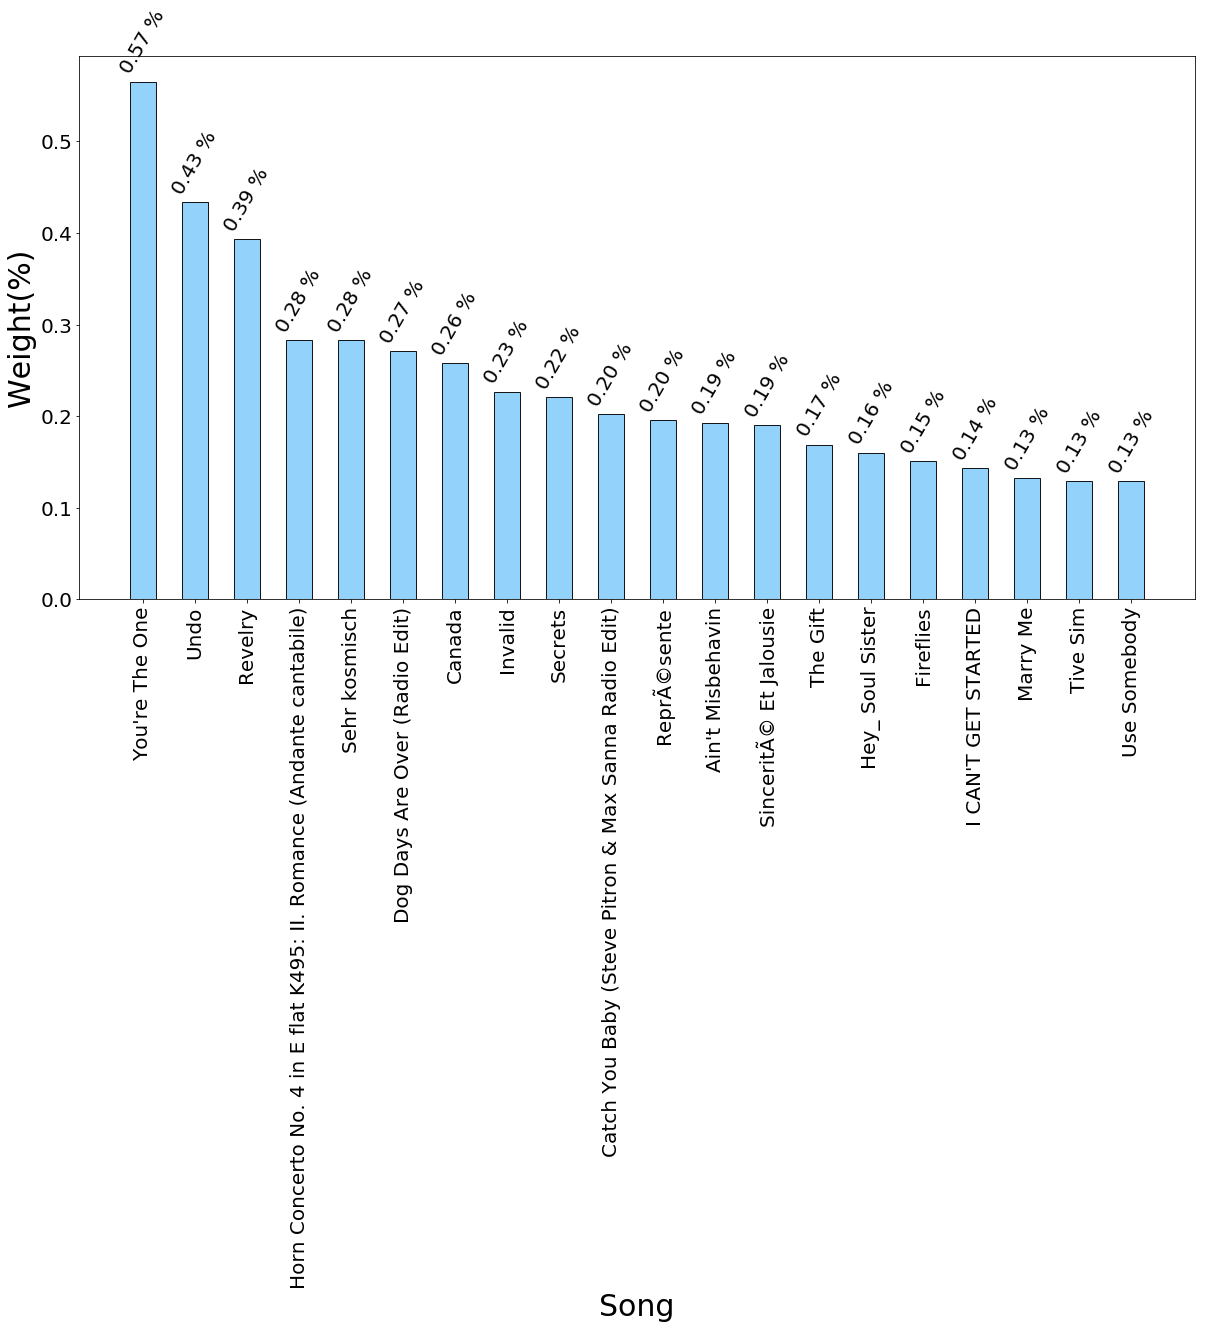

In [20]:
plot_popularity_recommendation_listen_count(song_dataset_sub_merged , 'title' , 'Song' , 'lightskyblue') 

### 基於總播放量_最受歡迎的專輯(前20名)

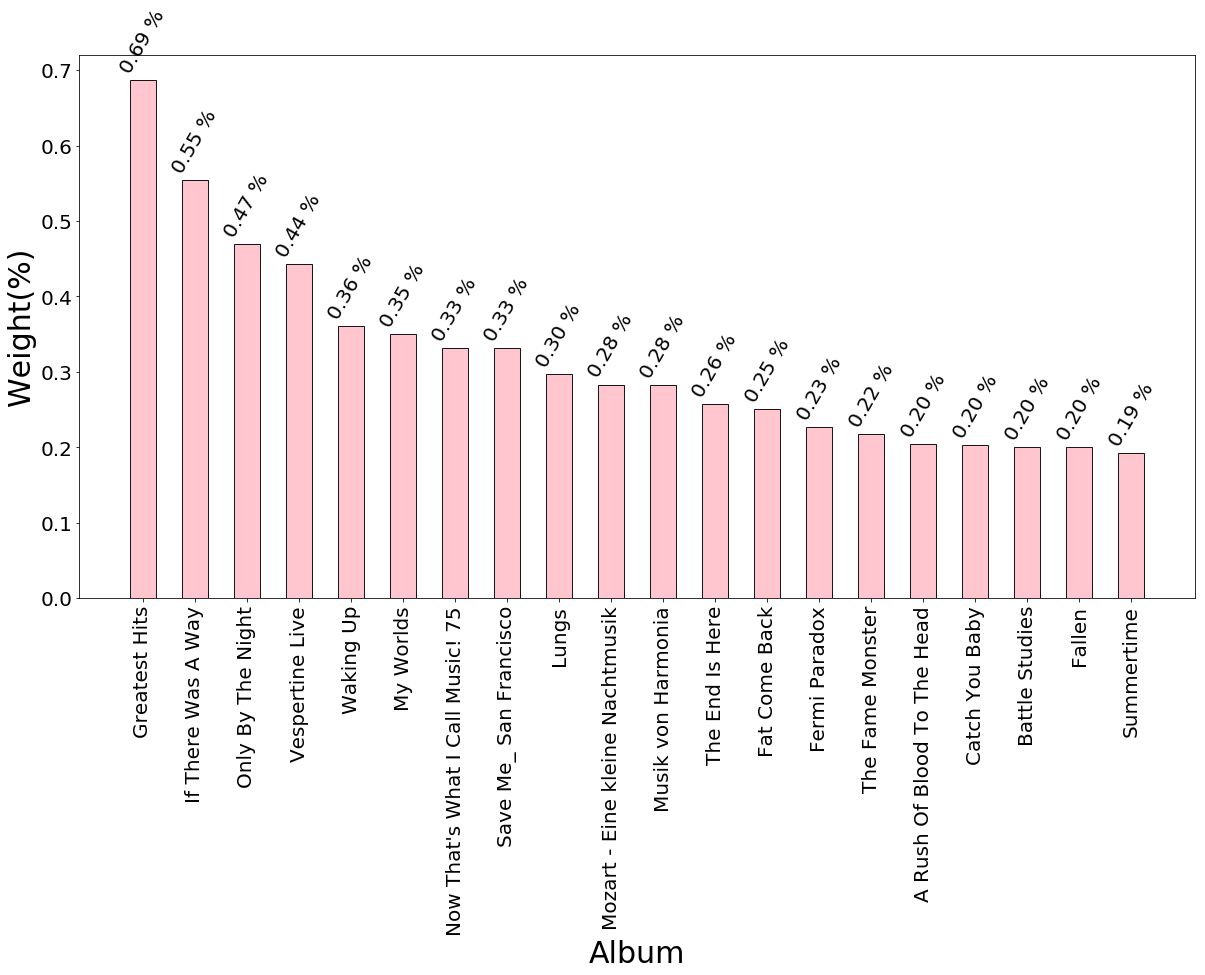

In [21]:
plot_popularity_recommendation_listen_count(song_dataset_sub_merged , 'release' , 'Album' , 'pink') 

### 基於總播放量_最受歡迎的歌手(前20名)

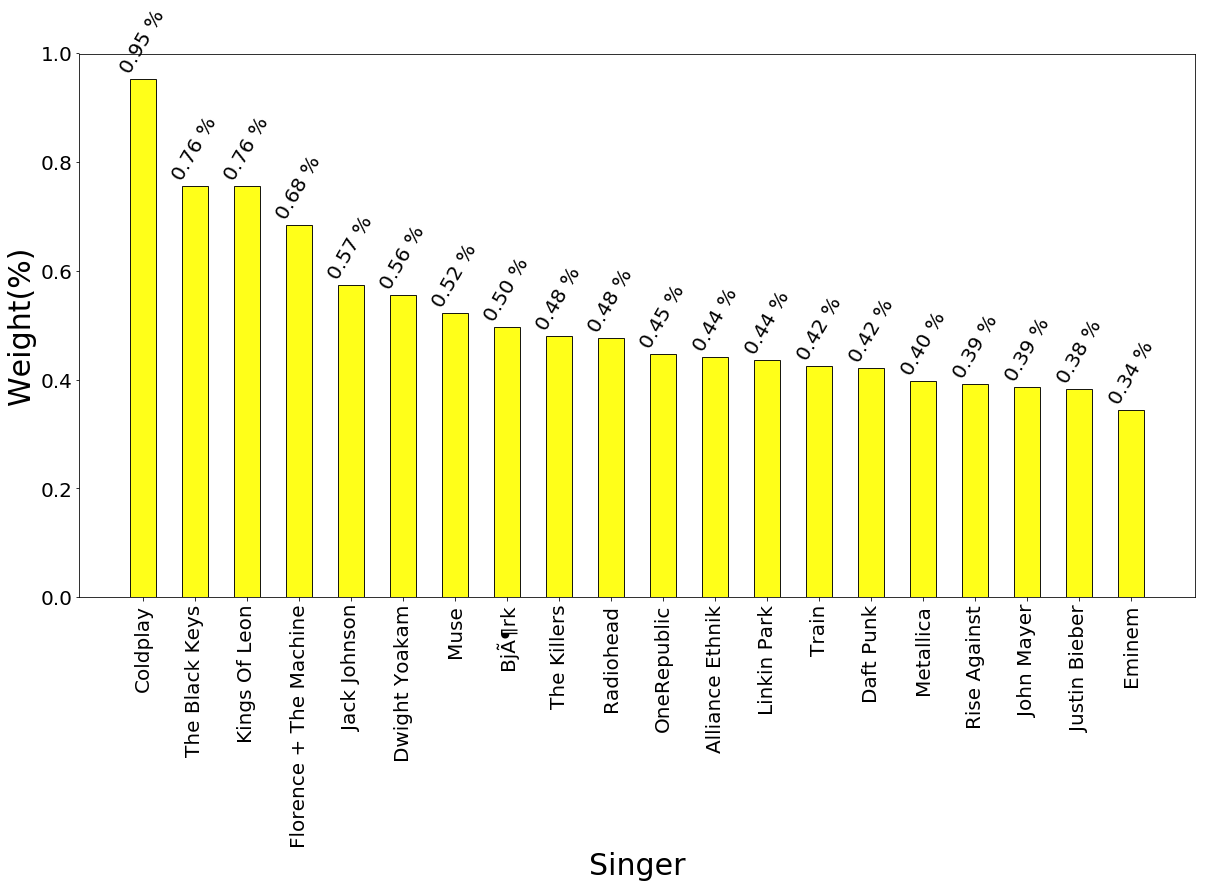

In [22]:
plot_popularity_recommendation_listen_count(song_dataset_sub_merged , 'artist_name' , 'Singer' , 'yellow') 

In [23]:
def create_popularity_recommendation_user_number(data , item):
    # item : title         => 計算每首歌曲有多少用戶聽過
    # item : release       => 計算每個專輯有多少用戶聽過
    # item : artist_name   => 計算每個歌手有多少用戶聽過
    
    # item 為 title(歌曲) 的狀況下
    # 計算有多少用戶播放過這首歌曲 
    # 若這首歌曲有越多用戶播放，代表這首歌曲排名越高
    def func(series):
        return series.count()
    popular = data[['user' , item]].groupby(item).apply(lambda x : func(x['user']))
    popular = popular.reset_index()
    
    # 將column的名字換掉
    popular.rename(columns = {0 : 'score'} , inplace = True)
    
    # 由大到小排序
    popular_top = popular.sort_values('score' , ascending = False)
    popular_top.reset_index(inplace = True)
    
    # 增加排名結果
    popular_top['rank'] = np.arange(1 , len(popular_top) + 1)
    
    # 取前20名的結果
    return popular_top.head(20)

### 基於有多少用戶聽過最受歡迎的歌曲(前20名)

In [24]:
recommendation = create_popularity_recommendation_user_number(song_dataset_sub_merged , 'title')
recommendation

,index,title,score,rank
0,19580,Sehr kosmisch,18626,1
1,5780,Dog Days Are Over (Radio Edit),17635,2
2,27314,You're The One,16085,3
3,19542,Secrets,15138,4
4,18636,Revelry,14945,5
5,25070,Undo,14687,6
6,7530,Fireflies,13085,7
7,9640,Hey_ Soul Sister,12993,8
8,25216,Use Somebody,12793,9
9,9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10


### 基於有多少用戶聽過最受歡迎的專輯(前20名)

In [25]:
recommendation = create_popularity_recommendation_user_number(song_dataset_sub_merged , 'release')
recommendation

,index,release,score,rank
0,4786,Greatest Hits,74197,1
1,7925,My Worlds,37006,2
2,7144,Lungs,30967,3
3,13737,Waking Up,27839,4
4,467,A Rush Of Blood To The Head,27008,5
5,9911,Save Me_ San Francisco,26407,6
6,8512,Only By The Night,25755,7
7,13566,Vampire Weekend,25603,8
8,11907,The Fame Monster,25040,9
9,8266,Now That's What I Call Music! 75,23291,10


### 基於有多少用戶聽過最受歡迎的歌手(前20名)

In [26]:
recommendation = create_popularity_recommendation_user_number(song_dataset_sub_merged , 'artist_name')
recommendation

,index,artist_name,score,rank
0,1686,Coldplay,125818,1
1,7505,The Black Keys,95067,2
2,7795,The Killers,74316,3
3,3594,Jack Johnson,72891,4
4,4298,Kings Of Leon,69684,5
5,6245,Radiohead,69342,6
6,1908,Daft Punk,64997,7
7,5467,Muse,64687,8
8,2850,Florence + The Machine,61106,9
9,5202,Metallica,46141,10


## 基于歌曲相似度的推薦，也可以說是以item為base的協同過濾

要針對某一個用戶進行推薦，那一定要先得到他聽過的歌曲，通過這些已被聽過的歌曲跟整個數據集中的歌曲進行對比，看哪些歌曲跟用戶已聽過的比較類似，推薦的就是這些類似的<br><br>
如何計算呢？例如當前用戶聽過了100首歌曲，整個數據集中有1000個歌曲，要做的就是創造一個[100 , 1000]的矩陣，其中每一個值表示用戶聽過的每一個歌曲和數據集中每一個歌曲的相似度<br><br>
這裡使用Jaccard相似系數，Jaccard矩陣中[i , j]的含義就是用戶聽過的第i首歌曲這些歌曲被哪些人聽過，數據集中的j歌曲被哪些人聽過

如果兩個歌曲很相似，那結果應該是一致的，交集/並集的比例應該比較大，如果兩個歌曲沒有什麼相關性，其值應當就比較小了<br><br>
一開始要對數據集中每一個待推薦的歌曲都需要跟該用戶所有聽過的歌曲計算其Jaccard值，例如歌曲j需要跟欲推薦用戶聽過的100個歌曲計算其值，最終是否推薦的得分值還要進行處理，需要把這100個值加在一起求平均，來代表該歌曲的推薦得分

<img src="jaccard.png" style="width:800px;height:160px;float:middle">

為了不要等程式跑太久，只用了比較少量的數據來分析，不過用以下這個程式來跑，不知道要跑到猴年馬月，迴圈惡夢!!!!!!

In [ ]:
sub_set = pd.read_csv(filepath_or_buffer = './sub_set.csv' , encoding = 'ISO-8859-1')
user = 'a974fc428825ed071281302d6976f59bfa95fe7e' # 針對某一個用戶進行推薦
total_song = list(set(sub_set['title'])) # 取得sub_set中所有的歌曲
user_song = list(set(sub_set.loc[sub_set['user'] == user]['title'])) # 取得欲推薦用戶聽過的所有歌曲

# 計算Jaccardr矩陣
jaccard = np.zeros((len(user_song) , len(total_song)))
for i , song_i in enumerate(user_song):
    for j , song_j in enumerate(total_song):

        # 把聽過i這首歌的人取出來
        user_set_i = set(sub_set.loc[sub_set['title'] == song_i]['user'])

        # 把聽過j這首歌的人取出來
        user_set_j = set(sub_set.loc[sub_set['title'] == song_j]['user'])

        # user_set_i、user_set_j 取交集
        intersection = list(user_set_j.intersection(user_set_i))

        if len(intersection) != 0:
            # user_set_i、user_set_j 取聯集
            union = list(user_set_i.union(user_set_j))
    
            # 交集 / 聯集
            jaccard[i , j] = len(intersection) / len(union)

        # 假如沒有交集，也就不需要計算聯集了
        elif len(intersection) == 0:
            jaccard[i , j] = 0  
            
score = jaccard.mean(axis = 0)
rank_index = score.argsort()[::-1] # score由大排到小的index全部取出來
for i in range(0 , 20):
    print(total_song[rank_index[i]])            

以下提供multiprocessing版本，以8核心的cpu運算，但光推薦一個用戶還是要花不少時間<br>
記得要在cmd下執行!!

In [ ]:
global sub_set , total_song , user_song
sub_set = pd.read_csv(filepath_or_buffer = './sub_set.csv' , encoding = 'ISO-8859-1')
user = 'a974fc428825ed071281302d6976f59bfa95fe7e' # 針對某一個用戶進行推薦
total_song = list(set(sub_set['title'])) # 取得sub_set中所有的歌曲
user_song = list(set(sub_set.loc[sub_set['user'] == user]['title'])) # 取得欲推薦用戶聽過的所有歌曲(此用戶共聽過66首歌曲)
total_song = sorted(total_song) # 排序以固定順序
user_song = sorted(user_song) # 排序以固定順序

def job(q , core , index):
    global sub_set , total_song , user_song
    target_song = user_song[index[0] : index[1]]
    jaccard = np.zeros((len(target_song) , len(total_song)))

    for i , song_i in enumerate(target_song):
        for j , song_j in enumerate(total_song):
    
            print('進度 => core : {} , 欲推薦用戶聽過的歌曲 : {} , 所有用戶聽過的歌曲 : {}'.format(core , i , j))
    
            # 把聽過i這首歌的人取出來
            user_set_i = set(sub_set.loc[sub_set['title'] == song_i]['user'])
    
            # 把聽過j這首歌的人取出來
            user_set_j = set(sub_set.loc[sub_set['title'] == song_j]['user'])
    
            # user_set_i、user_set_j 取交集
            intersection = list(user_set_j.intersection(user_set_i))

            if len(intersection) != 0:
                # user_set_i、user_set_j 取聯集
                union = list(user_set_i.union(user_set_j))
        
                # 交集 / 聯集
                jaccard[i , j] = len(intersection) / len(union)
    
            # 假如沒有交集，也就不需要計算聯集了，可以加快計算速度
            elif len(intersection) == 0:
                jaccard[i , j] = 0

    q.put([core , jaccard])


if __name__ == '__main__':
    # Jaccard matrix總共有66個row
    # 將Jaccard matrix的row分為8組(因為有8個core)處理，每1組core要處理8個row，而最後2組core要處理10個row

    # 決定好每個core要負責的row
    # 例如[8 , 16] => row : 8 ~ 15
    index_list = [[0 , 8] , [8 , 16] , [16 , 24] , [24 , 32] , [32 , 40] , [40 , 48] , [48 , 56] , [56 , 66]]
    processes = []
    manager = mp.Manager()
    q = manager.Queue()
    for core , index in enumerate(index_list):
        p = mp.Process(target = job , args = [q , core , index])
        p.start()
        processes.append(p)

    for process in processes:
        process.join()
    
    print('q.full()  : ' , q.full())
    outcome = []
    for _ in range(0 , len(processes)):
        outcome.append(q.get())
        print('q.qsize() : ' , q.qsize())

    # 將outcome按照core的順序排列
    # 可以讓Jaccard matrix的row的順序與user_song的順序相同
    outcome = sorted(outcome , key = lambda x : x[0])

    Jaccard = outcome[0][1]
    for i , jaccard in enumerate(outcome):
        if i > 0:
            Jaccard = np.vstack([Jaccard , jaccard[1]])

    # 將Jaccard matrix存檔
    np.save('Jaccard_matrix' , Jaccard)

In [ ]:
# 讀取Jaccard_matrix.npy，接著即可產生推薦名單
Jaccard_matrix = np.load('Jaccard_matrix.npy')
score = Jaccard_matrix.mean(axis = 0)
rank = score.argsort()[::-1] # score由大排到小的index全部取出來

for i in range(0 , 20):
    print(total_song[rank[i]])

## 基於矩陣分解（SVD）的推薦

相似度計算的方法概念相當簡單，但是計算的時間與資源實在太多了<br>

對每一個用戶都需要多次使用整個數據集來進行計算，矩陣分解的方法是更常使用的方法
奇異值分解(Singular Value Decomposition，SVD)是矩陣分解中一個常用方法，接下來的推薦就可以SVD來進行計算，奇異值分解的基本出發點跟隱語義模型有些類似都是將大矩陣轉換成小矩陣的乘積組合

### 先製作user與item矩陣，以下為範例(其實就是用merge的技巧)

In [27]:
ex = pd.DataFrame({'user':['Kevin' , 'Tom' , 'Mary' , 'Kevin' , 'Jane' , 'Chris' , 'Joy' , 'Tom' , 'Bird'] , 
                   'item':['出口' , '馬戲團運動' , '馬戲團運動' , '麋途' , '天黑' , '黃昏市長' , '麋途' , '沒名字的人類' , '出口'] ,
                   'score':[10 , 9 , 7 , 6 , 8 , 6 , 4 , 3 , 5]})
ex

,user,item,score
0,Kevin,出口,10
1,Tom,馬戲團運動,9
2,Mary,馬戲團運動,7
3,Kevin,麋途,6
4,Jane,天黑,8
5,Chris,黃昏市長,6
6,Joy,麋途,4
7,Tom,沒名字的人類,3
8,Bird,出口,5


In [28]:
# 決定user的index
user = ex['user'].drop_duplicates().reset_index()
user['user_index'] = user.index

# 決定item的index
item = ex['item'].drop_duplicates().reset_index()
item['item_index'] = item.index

# 製作row為user、column為song的矩陣
ex_ = pd.merge(left = ex , right = user , on = 'user'  , how = 'left')
ex_ = pd.merge(left = ex_ , right = item , on = 'item' , how = 'left')
ex_ = ex_.sort_values(by = 'user_index').reset_index(drop = True)
score = np.array(ex_.score)
user_index = np.array(ex_.user_index)
item_index = np.array(ex_.item_index)
sparse_matrix = coo_matrix((score , (user_index , item_index))).toarray()

In [29]:
ex_.drop(['index_x' , 'index_y'] , axis = 1 , inplace = True)
ex_

,user,item,score,user_index,item_index
0,Kevin,出口,10,0,0
1,Kevin,麋途,6,0,2
2,Tom,馬戲團運動,9,1,1
3,Tom,沒名字的人類,3,1,5
4,Mary,馬戲團運動,7,2,1
5,Jane,天黑,8,3,3
6,Chris,黃昏市長,6,4,4
7,Joy,麋途,4,5,2
8,Bird,出口,5,6,0


In [30]:
sparse_matrix

array([[10,  0,  6,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  3],
       [ 0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0,  6,  0],
       [ 0,  0,  4,  0,  0,  0],
       [ 5,  0,  0,  0,  0,  0]], dtype=int64)

在SVD中所需的數據是用戶對商品的評價分值，但是現在的數據集中只有用戶播放歌曲的情況並沒有實際的分數<br>
所以得自己來定義一下用戶對每個歌曲的評分值<br>
如果一個用戶喜歡某個歌曲，那應該經常播放這個歌曲，相反如果不喜歡某個歌曲，那播放次數一定比較少<br>
用戶對歌曲的分數 = 用戶播放該歌曲數量 / 該用戶播放總量

In [31]:
# 先根據用戶進行分組，在計算個別用戶的總播放量
def func(series):
    return series.sum()
song_dataset_sub_merged_sum_df = song_dataset_sub_merged[['user' , 'listen_count']].groupby('user').apply(lambda x : func(x['listen_count']))
song_dataset_sub_merged_sum_df = song_dataset_sub_merged_sum_df.reset_index()
song_dataset_sub_merged_sum_df.rename(columns = {0 : 'total_listen_count'} , inplace = True)

song_dataset_sub_merged = pd.merge(song_dataset_sub_merged , 
                                   song_dataset_sub_merged_sum_df , 
                                   how = 'left' , 
                                   left_on = 'user' ,
                                   right_on = 'user')

# 計算用戶對自己聽過的歌曲的分數
song_dataset_sub_merged['score'] = song_dataset_sub_merged['listen_count'] / song_dataset_sub_merged['total_listen_count']

In [32]:
# 決定user的index
user = song_dataset_sub_merged['user'].drop_duplicates().reset_index()
user['user_index'] = user.index

# 決定song的index
song = song_dataset_sub_merged['song'].drop_duplicates().reset_index()
song['song_index'] = song.index

# 製作row為user、column為song的矩陣
song_dataset_sub_merged_ = pd.merge(left = song_dataset_sub_merged , right = user , on = 'user'  , how = 'left')
song_dataset_sub_merged_ = pd.merge(left = song_dataset_sub_merged_ , right = song , on = 'song' , how = 'left')
score = np.array(song_dataset_sub_merged_['score'])
user_index = np.array(song_dataset_sub_merged_['user_index'])
song_index = np.array(song_dataset_sub_merged_['song_index'])
sparse_matrix = coo_matrix((score , (user_index , song_index)) , dtype = float)
sparse_matrix

<99996x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 10774558 stored elements in COOrdinate format>

### 使用SVD方法進行矩陣分解

In [33]:
K = 50
user_dim = sparse_matrix.shape[0]
song_dim = sparse_matrix.shape[1]

U , s , Vt = svds(sparse_matrix , K)

dim = (len(s) , len(s))
S = np.zeros(dim , dtype = np.float32)
for i in range(0 , len(s)):
    S[i , i] = mt.sqrt(s[i])

U = csc_matrix(U , dtype = np.float32)
S = csc_matrix(S , dtype = np.float32)
Vt = csc_matrix(Vt , dtype = np.float32)

在執行SVD的時候需要額外指定一個指標K值，其含義就是選擇前多少個特徵值來做近似代表，也就是S矩陣中的數量<br>
如果K值較大整體的計算效率會慢一些但是會更接近真實結果，這個值還需要自己來衡量一下<br>

這裡選擇K值等於50，user_dim表示用戶的數目，其中song_dim表示歌曲的數目

接下來需要選擇待測試用戶了 ⇨ user_list = [4 , 5 , 6 , 7 , 8]

隨便選擇一些用戶就好，這裡表示用戶的索引編號，接下來需要對每一個用戶計算其對候選集中30000首歌曲的喜好程度，也就是估計他對這30000首歌的評分值應該等於多少，前面通過SVD矩陣分解已經計算所需各個小矩陣了，接下來把其還原回去即可

In [34]:
recommend_num = 10 # 向用戶推薦的歌曲數目
estimate_rate = np.zeros((user_dim , song_dim) , dtype = np.float16)
recommend_index = np.zeros((user_dim , recommend_num) , dtype = np.float16)

user_list = [4 , 5 , 6 , 7 , 8] # 待測試用戶
for user in user_list:
    score = U[user , :] * S * Vt
    score = score.toarray()
    estimate_rate[user , :] = score
    # argsort() 返回的向量，第一個值是分數最低的index，最後一個值是分數最高的index
    # 所以最後加上[::-1]做一個反轉的功能，使第一個值是分數最高的index，最後一個值是分數最低的index
    recommend_index[user , :] = estimate_rate[user , :].argsort()[::-1][:recommend_num]

In [35]:
for user in user_list:
    user_id = song_dataset_sub_merged_[song_dataset_sub_merged_['user_index'] == user]['user'].iloc[0]
    print('\n用戶 : {}'. format(user_id))
    print('=' * 50)
    for i , index in enumerate(recommend_index[user , 0 : 10]):
        song_info = song_dataset_sub_merged_[song_dataset_sub_merged_['song_index'] == index].drop_duplicates('song_index')
        song_info = song_info[['title' , 'artist_name']]
        print('{} . 推薦歌曲 : {}  , 歌手 : {}'.format(i + 1 , song_info['title'].iloc[0] , song_info['artist_name'].iloc[0]))


用戶 : 3f152d355d53865a2ca27ac5ceeffb7ebaea0a26
1 . 推薦歌曲 : Fireflies  , 歌手 : Charttraxx Karaoke
2 . 推薦歌曲 : Hey_ Soul Sister  , 歌手 : Train
3 . 推薦歌曲 : OMG  , 歌手 : Usher featuring will.i.am
4 . 推薦歌曲 : Lucky (Album Version)  , 歌手 : Jason Mraz & Colbie Caillat
5 . 推薦歌曲 : Vanilla Twilight  , 歌手 : Owl City
6 . 推薦歌曲 : Crumpshit  , 歌手 : Philippe Rochard
7 . 推薦歌曲 : Billionaire [feat. Bruno Mars]  (Explicit Album Version)  , 歌手 : Travie McCoy
8 . 推薦歌曲 : Love Story  , 歌手 : Taylor Swift
9 . 推薦歌曲 : TULENLIEKKI  , 歌手 : M.A. Numminen
10 . 推薦歌曲 : Use Somebody  , 歌手 : Kings Of Leon

用戶 : 732f88be38fae217f8ab7e24c20dd072436e3e40
1 . 推薦歌曲 : Sehr kosmisch  , 歌手 : Harmonia
2 . 推薦歌曲 : Ain't Misbehavin  , 歌手 : Sam Cooke
3 . 推薦歌曲 : Dog Days Are Over (Radio Edit)  , 歌手 : Florence + The Machine
4 . 推薦歌曲 : Revelry  , 歌手 : Kings Of Leon
5 . 推薦歌曲 : Undo  , 歌手 : BjÃ¶rk
6 . 推薦歌曲 : Cosmic Love  , 歌手 : Florence + The Machine
7 . 推薦歌曲 : Home  , 歌手 : Edward Sharpe & The Magnetic Zeros
8 . 推薦歌曲 : You've Got The Love  , 歌手 